# Visualize maximum SWE, mean soil water, mean ET and mean runoff per GRU
Needs: 
- Catchment shapefile with GRU delineation
- River shapefile with network delineation
- SUMMA output `scalarSWE`, `scalarTotalSoilWat`, `scalarTotalET`
- mizuRoute output `IRFroutedRunoff`

#### Special note
SUMMA and mizuRoute simulations have been preprocessed into single value statistics per model element, using auxiliary scripts in `~/summaWorkflow_public/0_tools/`. Paths to the `.nc` files that contain these statistics are not read from the `control_active.txt` file but hard-coded the sections "Simulation statistics file locations" below.

To improve visualization of large lakes, HydroLAKES lake delineations are plotted on top of the catchment GRUs and river segments. Dealing with HydroLAKES inputs is not considered within scope of the workflow and therefore requires some manual downloading and preprocessing of this data for those who wish to reproduce this step. The relevant code is easily disabled by switching the `plot_lakes = True` flag to `False`.

In [1]:
# modules
import pyproj
import matplotlib
import numpy as np
import xarray as xr
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from geocube.api.core import make_geocube
import cartopy.crs as ccrs
import rioxarray
%matplotlib inline

#### Simulation statistics file locations

In [3]:
# SUMMA simulations
summa_output_path = Path('/Users/darrieythorsson/compHydro/data/CWARHM_data/domain_Iceland/simulations/run_Iceland_TDX_1/SUMMA')
summa_output_name = 'run_Iceland_TDX_1_day.nc'

In [4]:
# mizuRoute simulations
mizu_output_path = Path('/Users/darrieythorsson/compHydro/data/CWARHM_data/domain_Hawaii/simulations/run_Hawaii_TDX_1/mizuRoute')
mizu_output_name = 'run_Hawaii_TDX_1.h.1950-12-01-00000.nc'

#### Plot lakes?

In [5]:
plot_lakes = True

In [6]:
# lakes shapefile
lake_path = Path('/Users/darrieythorsson/compHydro/data/Shapefiles/HydroLAKES/HydroLAKES_polys_v10_shp')
lake_name = 'HydroLAKES_polys_v10_subset_YK.shp'

#### Control file handling

In [7]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')

In [8]:
# Store the name of the 'active' file in a variable
controlFile = 'control_Iceland.txt'

In [9]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [10]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Define where to save the figure

In [11]:
# Path and filename
fig_path = read_from_control(controlFolder/controlFile,'visualization_folder')
fig_name = 'max_swe_AND_mean_sm_AND_mean_et_AND_mean_q_FOR_Iceland_v4_compressed.png'

# Specify default path if needed
if fig_path == 'default':
    fig_path = make_default_path('visualization') # outputs a Path()
else:
    fig_path = Path(fig_path) # make sure a user-specified path is a Path()
    
# Make the folder if it doesn't exist
fig_path.mkdir(parents=True, exist_ok=True)

#### Catchment shapefile location and variable names

In [12]:
# HM catchment shapefile path & name
hm_catchment_path = read_from_control(controlFolder/controlFile,'catchment_shp_path')
hm_catchment_name = read_from_control(controlFolder/controlFile,'catchment_shp_name')

# Specify default path if needed
if hm_catchment_path == 'default':
    hm_catchment_path = make_default_path('shapefiles/catchment') # outputs a Path()
else:
    hm_catchment_path = Path(hm_catchment_path) # make sure a user-specified path is a Path()

In [13]:
# Find the GRU and HRU identifiers
hm_hruid = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')

#### River network shapefile location and variable names

In [14]:
# River network path & name
river_network_path = read_from_control(controlFolder/controlFile,'river_network_shp_path')
river_network_name = read_from_control(controlFolder/controlFile,'river_network_shp_name')

# Specify default path if needed
if river_network_path == 'default':
    river_network_path = make_default_path('shapefiles/river_network') # outputs a Path()
else:
    river_network_path = Path(river_network_path) # make sure a user-specified path is a Path()

In [15]:
# Find the segment ID
seg_id = read_from_control(controlFolder/controlFile,'river_network_shp_segid')

#### Load all shapefiles and project to Albers Conformal Conic

In [16]:
# catchment shapefile
bas = gpd.read_file(hm_catchment_path/hm_catchment_name)

In [17]:
# river network shapefile
riv = gpd.read_file(river_network_path/river_network_name)

In [18]:
# lakes shapefile
if plot_lakes:
    lakes = gpd.read_file(lake_path/lake_name)

In [19]:
# Set the target CRS
acc = 'ESRI:102008'

In [20]:
# Reproject
bas_albers = bas.to_crs(acc)
riv_albers = riv.to_crs(acc)
lak_albers = lakes.to_crs(acc)

In [21]:
# Print the median basin size for curiousity
print('median area = {} m^2'.format(bas['HRU_area'].median() / 10**6))
print('mean area   = {} m^2'.format(bas['HRU_area'].mean() / 10**6))

median area = 7.2641590495 m^2
mean area   = 8.983223795096961 m^2


In [22]:
# Get the albers shapes
main = Path('/Users/darrieythorsson/compHydro/data/CWARHM_data/domainYukon/shapefiles/albers_projection')
if False:
    lak_albers = gpd.read_file(main/'lakes.shp')
    riv_albers = gpd.read_file(main/'river.shp')
    bas_albers = gpd.read_file(main/'basin.shp')

### Pre-processing
#### Map SUMMA sims to catchment shapes

In [23]:
# Get the aggregated statistics of SUMMA simulation
summa = xr.open_dataset(summa_output_path/summa_output_name)
summa

<xarray.Dataset> Size: 2GB
Dimensions:                (time: 1825, hru: 10863, gru: 10863)
Coordinates:
  * time                   (time) datetime64[ns] 15kB 1950-01-02 ... 1954-12-31
  * hru                    (hru) int64 87kB 7 8 9 10 ... 10892 10893 10894 10895
  * gru                    (gru) int64 87kB 7 8 9 10 ... 10892 10893 10894 10895
Data variables: (12/17)
    scalarCanopyWat        (time, hru) float64 159MB ...
    scalarSWE              (time, hru) float64 159MB ...
    scalarAquiferStorage   (time, hru) float64 159MB ...
    scalarTotalSoilWat     (time, hru) float64 159MB ...
    scalarSenHeatTotal     (time, hru) float64 159MB ...
    scalarLatHeatTotal     (time, hru) float64 159MB ...
    ...                     ...
    scalarAquiferBaseflow  (time, hru) float64 159MB ...
    scalarTotalET          (time, hru) float64 159MB ...
    scalarTotalRunoff      (time, hru) float64 159MB ...
    scalarNetRadiation     (time, hru) float64 159MB ...
    hruId                  (hru) int64 87kB ...
    gruId                  (gru) int64 87kB ...
Attributes: (12/32)
    summaVersion:     undefined
    buildTime:        Fri 16 Feb 2024 08:37:03 MST
    gitBranch:        main-0-g8540d65
    gitHash:          8540d65e99f9fde311900d4e23934f40b3ce8bd7
    soilCatTbl:       ROSETTA
    vegeParTbl:       MODIFIED_IGBP_MODIS_NOAH
    ...               ...
    snowLayers:       CLM_2010
    compaction:       anderson
    thCondSnow:       jrdn1991
    thCondSoil:       funcSoilWet
    spatial_gw:       localColumn
    subRouting:       timeDlay

In [24]:
# Specify variables of interest
plot_vars = ['scalarSWE','scalarTotalET','scalarTotalSoilWat']

In [25]:
# Match the accummulated values to the correct HRU IDs in the shapefile
hru_ids_shp = bas_albers[hm_hruid].astype(int) # hru order in shapefile





In [26]:
# Match the accummulated values to the correct HRU IDs in the shapefile
hru_ids_shp = bas_albers[hm_hruid].astype(int) # hru order in shapefile

for plot_var in plot_vars:
    bas_albers[plot_var] = summa[plot_var].sel(hru=hru_ids_shp.values, time = '1953-12-31').values

KeyError: "not all values found in index 'hru'"

In [ ]:
hru_ids_shp = riv_albers[hm_hruid].astype(int)
hru_ids_shp

#### Map mizuRoute sims to river shapes

In [27]:
# Get the aggregated statistics of mizuRoute simulations
mizu = xr.open_dataset(mizu_output_path/mizu_output_name)#.sel(time = ['1950','1954'])
print(mizu)
#mizu['IRFroutedRunoff']

<xarray.Dataset> Size: 144MB
Dimensions:          (time: 744, seg: 11129, hru: 14861)
Coordinates:
  * time             (time) datetime64[ns] 6kB 1950-11-30T23:59:59.999986688 ...
Dimensions without coordinates: seg, hru
Data variables:
    reachID          (seg) int32 45kB ...
    basinID          (hru) int32 59kB ...
    basRunoff        (time, hru) float32 44MB ...
    instRunoff       (time, seg) float32 33MB ...
    dlayRunoff       (time, seg) float32 33MB ...
    IRFroutedRunoff  (time, seg) float32 33MB ...
Attributes:
    mizuRoute-version:  v1.2.2
    gitBranch:          develop-0-geb77a0d
    gitHash:            eb77a0d2d4684ea55ac2a42b7c0dd3c8f7e958b3


In [38]:
reach = mizu.sel(seg = mizu['reachID'] == 1700)
reach['IRFroutedRunoff'].plot()

TypeError: No numeric data to plot.

In [ ]:
summa['scalarSWE'].sel(hru = 1050).plot()

In [33]:
# Specify variables of interest
mizu_vars = ['IRFroutedRunoff']#,'KWTroutedRunoff']

In [30]:
# polygon order in the simulation file
seg_ids_sim = mizu['reachID'].values

In [31]:
# ensure that the shapefile is in the same order as the sims
riv_albers = riv_albers.set_index(riv_albers[seg_id].astype('int'))
riv_albers = riv_albers.reindex(seg_ids_sim)

In [34]:
# Match the accummulated values to the correct HRU IDs in the shapefile
seg_ids_riv = riv_albers.index.values # hru order in shapefile
for mizu_var in mizu_vars:
    riv_albers[mizu_var] = mizu[mizu_var].sel(seg=np.where(mizu['reachID'].values == seg_ids_riv)[0]).values[0]

In [35]:
# Add a linewidth column for the river network
riv_albers['lineWidth'] = np.maximum(np.log10(riv_albers['IRFroutedRunoff'] ),0)
print(riv_albers)

           fid  LINKNO  DSLINKNO  USLINKNO1  USLINKNO2  DSNODEID  strmOrder  \
LINKNO                                                                        
800013463  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800015683  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800015684  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800015699  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800015700  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
...        ...     ...       ...        ...        ...       ...        ...   
800013853  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800000647  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800013854  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800011653  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800007188  NaN     NaN       NaN        NaN        N

#### Select lakes of a certain size for plotting

In [ ]:
if plot_lakes:
    minSize = 1000 # km2
    in_domain = (lak_albers['Country'] == 'Canada') | \
                (lak_albers['Country'] == 'United States of America') 
    out_domain = (lak_albers['Pour_long'] > -80) & (lak_albers['Pour_lat'] > 65) # Exclude Baffin Island
    large_lakes_albers = lak_albers.loc[(lak_albers['Lake_area'] > minSize) & in_domain & (~out_domain) ]

In [ ]:
# Set the lake color
if plot_lakes:
    lake_col = (8/255,81/255,156/255)

### Figure

In [36]:
# Set the font size: we need this to be huge so we can also make our plotting area huge, to avoid a gnarly plotting bug
if 'compressed' in fig_name:
    plt.rcParams.update({'font.size': 25})
else:
    plt.rcParams.update({'font.size': 100})

In [ ]:
# Flip the evaporation values so that they become positive
bas_albers['plot_ET'] = bas_albers['scalarTotalET'] * -1
bas_albers['plot_ET'] = bas_albers['plot_ET'].where(bas_albers['scalarTotalET'] != -9999, np.nan)


/var/folders/pc/q8630ffx72z0bwfzz59ws0kc0000gn/T/ipykernel_7854/1170767490.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.drop('LINKNO', axis = 1).to_file("/Users/darrieythorsson/compHydro/data/HawaiiDisTDX.shp")


           fid  LINKNO  DSLINKNO  USLINKNO1  USLINKNO2  DSNODEID  strmOrder  \
LINKNO                                                                        
800013463  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800015683  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800015684  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800015699  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800015700  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
...        ...     ...       ...        ...        ...       ...        ...   
800013853  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800000647  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800013854  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800011653  NaN     NaN       NaN        NaN        NaN       NaN        NaN   
800007188  NaN     NaN       NaN        NaN        N

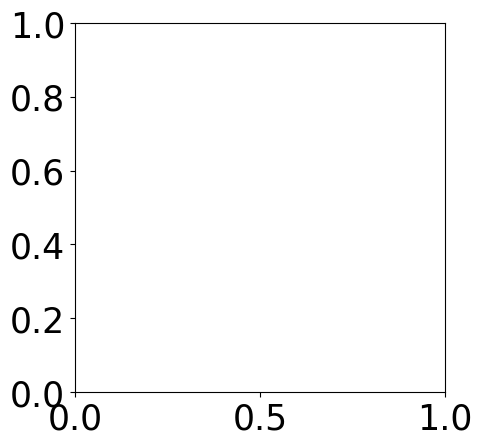

In [37]:
riv_albers

gdf = gpd.GeoDataFrame(
    riv_albers,
    geometry=riv_albers.geometry
)
gdf.drop('LINKNO', axis = 1).to_file("/Users/darrieythorsson/compHydro/data/HawaiiDisTDX.shp")
#gdf.drop('LINKNO', axis = 1).to_file("/Users/darrieythorsson/compHydro/data/YukonDisTDX.shp")
gdf.plot() # first image hereunder
print(gdf)

#geotif_file = "/Users/darrieythorsson/compHydro/data/raster.tif"
#out_grd = make_geocube(
#    vector_data=gdf,
#    measurements=["IRFroutedRunoff"],
#    resolution = [100,100]
#)

#out_grd["IRFroutedRunoff"].rio.to_raster(geotif_file)

In [ ]:
'''if 'compressed' in fig_name:
    fig,axs = plt.subplots(2,2,figsize=(35,33))
else:
    fig,axs = plt.subplots(2,2,figsize=(140,133))

# colorbar axes

cax2 = fig.add_axes([0.97 ,0.60,0.02,0.3])
cax3 = fig.add_axes([0.473,0.10,0.02,0.3])

'''


fig,axs = plt.subplots(figsize=(140,133))
plt.tight_layout()
'''
cax1 = fig.add_axes([0.473,0.60,0.02,0.3])
# add maps
bas_albers.plot(ax=axs, column='scalarSWE', edgecolor='none', legend=True, vmin=0, vmax=200, \
                cmap='Greys_r', cax=cax1, zorder=0)
axs.set_title('(a) Maximum simulated Snow Water Equivalent')
axs.axis('off')
cax1.set_ylabel('scalarSWE $[kg~m^{-2}]$',labelpad=-600)

# SM
bas_albers.plot(ax=axs[0,1], column='scalarTotalSoilWat', edgecolor='none', legend=True, vmin=0, \
                cmap='cividis_r', cax=cax2, zorder=0)
axs[0,1].set_title('(b) Mean simulated total soil water content')
axs[0,1].axis('off')
cax2.set_ylabel('scalarTotalSoilWat $[kg~m^{-2}]$',labelpad=-600)

# ET
bas_albers.plot(ax=axs[1,0], column='plot_ET', edgecolor='none', legend=True,\
                cmap='viridis', cax=cax3, zorder=0)
axs[1,0].set_title('(c) Mean simulated total evapotranspiration')
axs[1,0].axis('off')
cax3.set_ylabel('scalarTotalET $[kg~m^{-2}~s^{-1}]$',labelpad=-450)
'''
# Flow
cax4 = fig.add_axes([0.97 ,0.10,0.02,0.3])
var = 'IRFroutedRunoff'
norm = matplotlib.colors.LogNorm(vmin=riv_albers[var].min(), vmax=riv_albers[var].max())
riv_albers.plot(ax=axs,column=var, linewidth=riv_albers['lineWidth']*10, \
                                    cmap='Blues', legend=True, cax=cax4, norm=norm, zorder=0)
axs.set_title('(d) Mean simulated streamflow')
axs.axis('off')

'''
# lakes
if plot_lakes:
    large_lakes_albers.plot(ax=axs, color=lake_col, zorder=1)
    #large_lakes_albers.plot(ax=axs[0,1], color=lake_col, zorder=1)
    #large_lakes_albers.plot(ax=axs[1,0], color=lake_col, zorder=1)
    #large_lakes_albers.plot(ax=axs[1,1], color=lake_col, zorder=1)

# Save 
plt.savefig(fig_path/fig_name, bbox_inches='tight', transparent=True)
'''